In [1]:
import pandas as pd
import scipy.io
import numpy as np
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import time
rand_state = 42
np.random.seed(rand_state)

import warnings
warnings.simplefilter('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
qm7 = scipy.io.loadmat('/kaggle/input/atomizationpredict/qm7.mat')

In [3]:
R = qm7['R']
print(R)
print(qm7['T'])

[[[ 1.8864380e+00 -4.6487264e-03 -8.2392059e-03]
  [ 3.9499245e+00 -4.5920345e-03  7.8234663e-03]
  [ 1.1976895e+00  1.9404842e+00  7.8234663e-03]
  ...
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]

 [[ 1.8973607e+00 -5.5746920e-03 -1.2094247e-02]
  [ 4.7544756e+00 -1.3265877e-02  1.1149384e-03]
  [ 1.1760710e+00  1.9320560e+00 -3.0991510e-03]
  ...
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]

 [[ 1.8692415e+00  1.8897261e-04  0.0000000e+00]
  [ 4.3934622e+00 -3.2125344e-04 -0.0000000e+00]
  [ 8.1146729e-01  1.7577099e+00  0.0000000e+00]
  ...
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]

 ...

 [[ 4.1100221e+00 -1.0346062e+00  2.6948628e+00]
  [ 4.3785710e+00  6.1529484e-02  4.884

In [4]:
y = np.transpose(qm7['T']).reshape((7165,))
y_scaling_factor = 2000. 
y_scaled = y / y_scaling_factor

# k=0 # 0 = include diagnol, 1 = do not include diagnol

num_atom = 23
iu = np.triu_indices(num_atom, k=0)
iu_dist = np.triu_indices(num_atom, k=1)

CM = np.zeros((qm7['X'].shape[0], num_atom*(num_atom + 1)// 2), dtype = float)
eigen = np.zeros((qm7['X'].shape[0], num_atom), dtype=float)
centralities = np.zeros((qm7['X'].shape[0], num_atom), dtype = float)
interatomic_dist = np.zeros((qm7['X'].shape[0], ((num_atom*num_atom)-num_atom)//2), dtype=float)

verbose = True

for i, cm in enumerate(qm7['X']):
    coulomb_vector = cm[iu]
    shuffle = np.argsort(-coulomb_vector)
    CM[i] = coulomb_vector[shuffle]
    dist = squareform(pdist(R[i]))
    
    dist_vector = dist[iu_dist]
    shuffle = np.argsort(-dist_vector)
    interatomic_dist[i] = dist_vector[shuffle]
    
    w, v = np.linalg.eig((dist))
    eigen[i] = w[np.argsort(-w)]
    centralities[i] = np.array(list(nx.eigenvector_centrality(nx.Graph(dist)).values()))
    
    if verbose and i % 500 == 0:
        print("Process {} molecules".format(i))

X = np.concatenate((CM, eigen, centralities, interatomic_dist), axis = 1)
X.shape

Process 0 molecules
Process 500 molecules
Process 1000 molecules
Process 1500 molecules
Process 2000 molecules
Process 2500 molecules
Process 3000 molecules
Process 3500 molecules
Process 4000 molecules
Process 4500 molecules
Process 5000 molecules
Process 5500 molecules
Process 6000 molecules
Process 6500 molecules
Process 7000 molecules


(7165, 575)

In [5]:
print(X)

[[36.85810471  2.90763259  2.90761209 ...  0.          0.
   0.        ]
 [36.85810471 36.85810471 12.59994411 ...  0.          0.
   0.        ]
 [36.85810471 36.85810471 14.26182747 ...  0.          0.
   0.        ]
 ...
 [53.35870743 36.85810471 36.85810471 ...  0.          0.
   0.        ]
 [36.85810471 36.85810471 36.85810471 ...  0.          0.
   0.        ]
 [36.85810471 36.85810471 36.85810471 ...  0.          0.
   0.        ]]


In [6]:
def mean_dist(x):
    x[x==0] = np.nan
    return np.nanmean(x, axis = 0)

mean_dists = np.apply_along_axis(mean_dist, axis=1, arr = interatomic_dist)

## Visualization

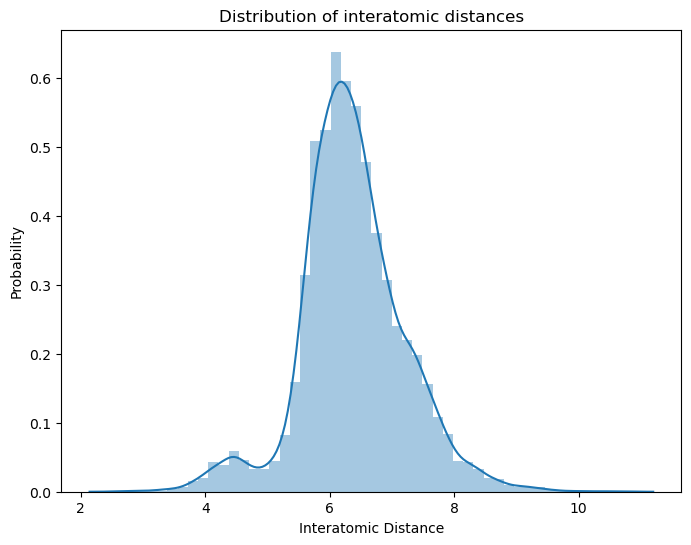

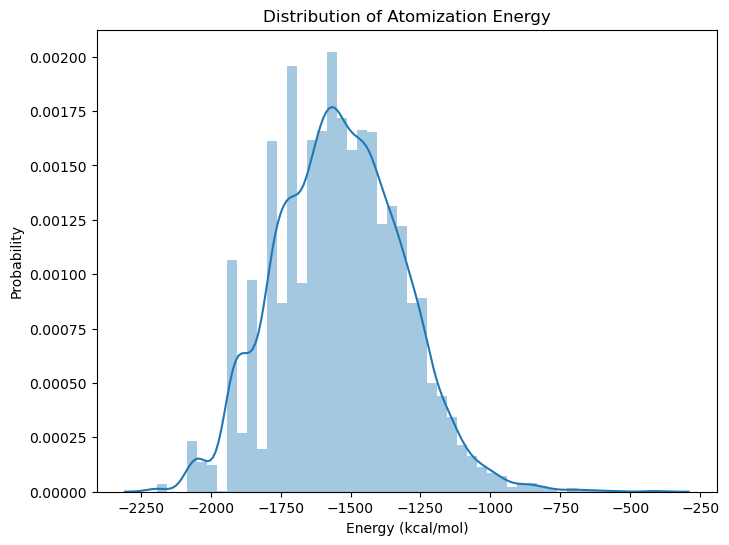

In [7]:
plt.figure(figsize=(8,6))
sns.distplot(mean_dists)
plt.xlabel('Interatomic Distance')
plt.ylabel('Probability')
plt.title('Distribution of interatomic distances')
plt.show()

plt.figure(figsize=(8,6))
sns.distplot(y)
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Probability')
plt.title('Distribution of Atomization Energy')
plt.show()

## Dimensionality Reduction

--- 1.9162514209747314 seconds ---
Variance Explained:  1.0


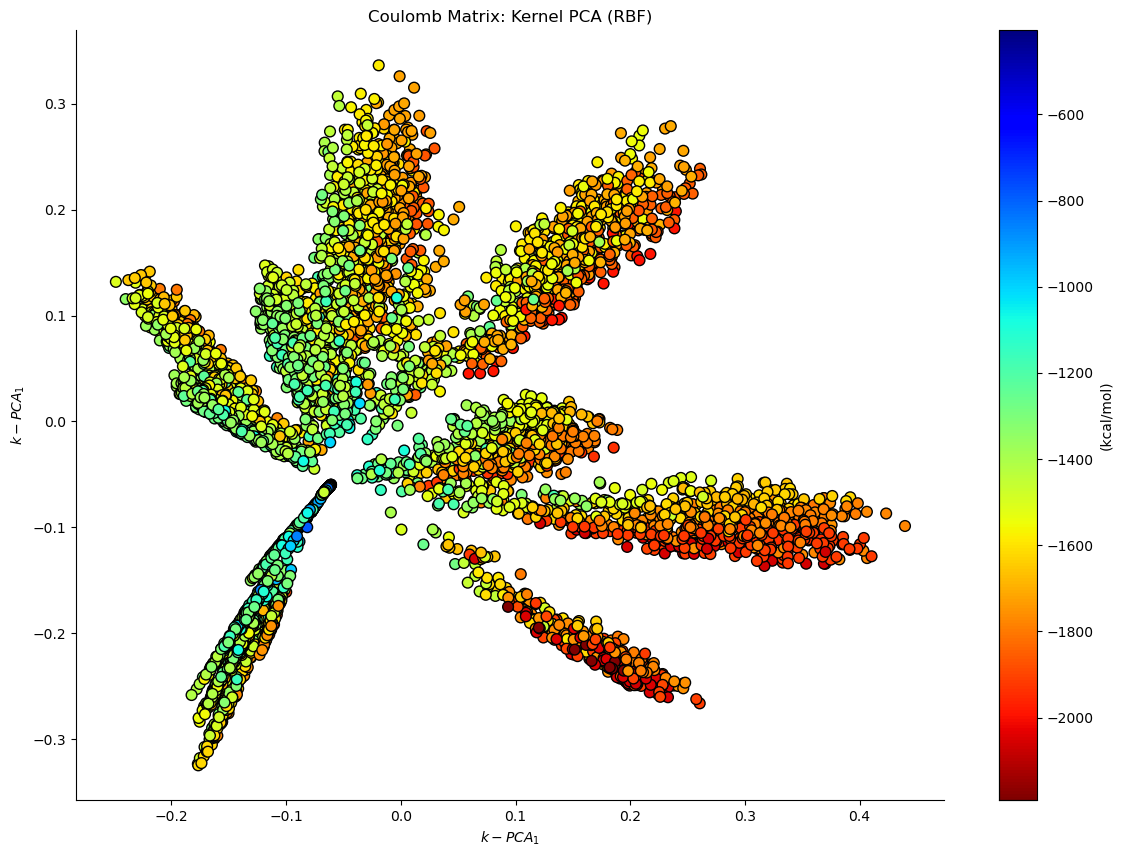

In [8]:
from sklearn.decomposition import KernelPCA
from matplotlib import cm

# scale Coulomb Matrices, divide by 370
CM = qm7['X'].reshape((7165, 529))


start_time = time.time()
kpca = KernelPCA(n_components=2, kernel="rbf")
CM_reduced = kpca.fit_transform(CM)
print("--- %s seconds ---" % (time.time() - start_time))
explained_variance = np.var(CM_reduced, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
print("Variance Explained: ", np.sum(explained_variance_ratio))

fig = plt.figure(figsize=(14,10))
ax  = fig.add_subplot(111)

scatter = ax.scatter(CM_reduced[:,0], CM_reduced[:,1], c=y, s=60, edgecolors='black', cmap=cm.jet_r)
colorbar = fig.colorbar(scatter, ax=ax, label = "(kcal/mol)")
plt.xlabel(r'$k-PCA_1$')
plt.ylabel(r'$k-PCA_1$')
plt.title("Coulomb Matrix: Kernel PCA (RBF)")
sns.despine()
plt.show()

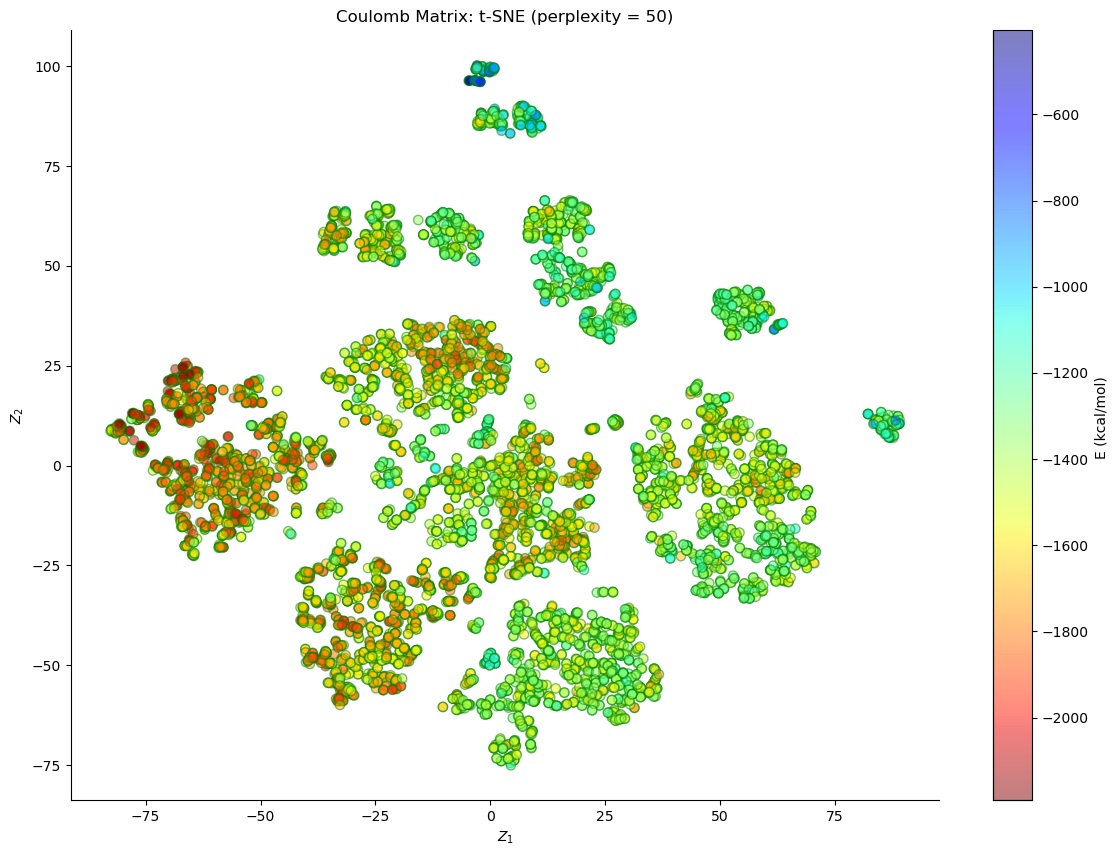

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=rand_state, perplexity=50)
X_tsne = tsne.fit_transform(CM)

fig = plt.figure(figsize=(14,10))
ax  = fig.add_subplot(111)

scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=45, edgecolors='green', cmap=cm.jet_r, alpha=0.5)
colorbar = fig.colorbar(scatter, ax=ax, label = "E (kcal/mol) ")
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')
plt.title('Coulomb Matrix: t-SNE (perplexity = 50)')
sns.despine()
plt.show()

## Build the model

In [10]:
def get_category(x, total_range, num_bins):
    bin_size = total_range/num_bins
    total_range = 1787.119995
    bin_size = total_range/num_bins

    return int(np.floor(np.abs(x/bin_size)))

total_range = 1787.119995
num_bins = 10

y_class = pd.Series(y).apply(lambda x: get_category(x, total_range, num_bins))

### Classification

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_2, X_val, y_class_2, y_class_val = train_test_split(X, y_class.values, 
                                                    test_size=0.15, 
                                                    random_state=rand_state)

# with cross validation no need to further split the data. if not using cross validation you should do one...
X_train, X_dev, y_class_train, y_class_dev = train_test_split(X_2, y_class_2, 
                                                    test_size=0.18, 
                                                    random_state=rand_state)

clf = SVC(kernel='linear', random_state=rand_state)
clf.fit(X_train, y_class_train)
print("Train score: ", clf.score(X_train, y_class_train))
print("Test score: ", clf.score(X_dev, y_class_dev))

print('--------\nEVALUATE on validation set\n--------')
class_preds = clf.predict(X_val)
print("Validation score: ", accuracy_score(y_class_val, class_preds))
print(classification_report(y_class_val, class_preds))

Train score:  0.9521329861806529
Test score:  0.877848678213309
--------
EVALUATE on validation set
--------
Validation score:  0.8902325581395348
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         1
           4       0.60      1.00      0.75         3
           5       0.67      0.57      0.62        14
           6       0.80      0.82      0.81        83
           7       0.88      0.90      0.89       214
           8       0.91      0.91      0.91       318
           9       0.93      0.88      0.90       307
          10       0.84      0.93      0.88       115
          11       1.00      1.00      1.00        19
          12       1.00      1.00      1.00         1

    accuracy                           0.89      1075
   macro avg       0.86      0.90      0.88      1075
weighted avg       0.89      0.89      0.89      1075



### Regression

In [27]:
# Using Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
X = np.concatenate((CM, eigen, centralities), axis=1)


# with cross validation no need to further split the data. if not using cross validation you should do one...
X_2, X_val, y_2, y_val = train_test_split(X, y, 
                                          test_size=0.15, 
                                          random_state=rand_state)

# with cross validation no need to further split the data. if not using cross validation you should do one...
X_train, X_dev, y_train, y_dev = train_test_split(X_2, y_2, 
                                                  test_size=0.18, 
                                                  random_state=rand_state)


KRR = KernelRidge(alpha=1.0, kernel='polynomial',degree=4)
model = KRR.fit(X_train,y_train)
print("Train score: ", model.score(X_train, y_train))
print("Test score: ", model.score(X_dev, y_dev))

print('--------\nEVALUATE on validation set\n--------')
reg_val_pred = model.predict(X_val)
print('Validation mean absoulte error: ', mean_absolute_error(y_val, reg_val_pred))

Train score:  0.9999999864533239
Test score:  0.46819393708664714
--------
EVALUATE on validation set
--------
Validation mean absoulte error:  22.990607846271274


--- 46.483664989471436 seconds ---


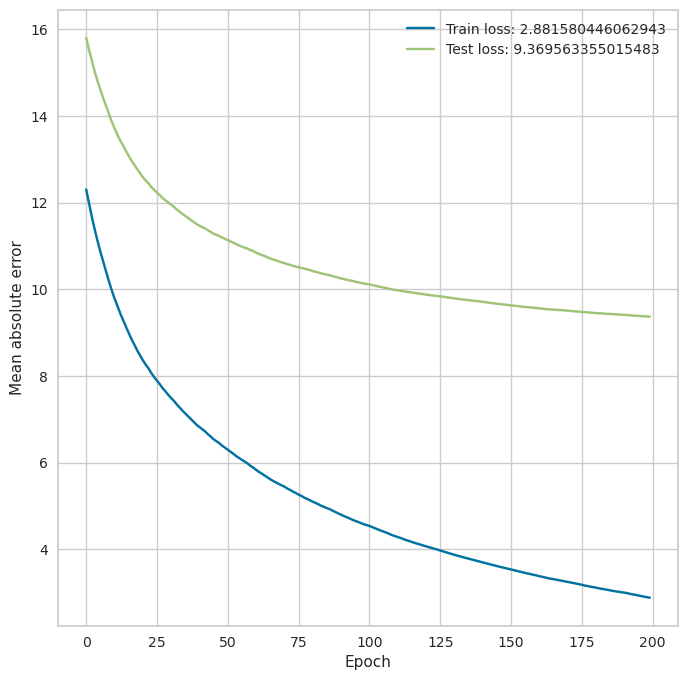

Train score:  0.9996590919907203
Test score:  0.9967874438377259
Dev mean absoulte error:  9.052369
Validation mean absoulte error:  8.828554


In [26]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = np.concatenate((CM, eigen, centralities), axis=1)


# with cross validation no need to further split the data. if not using cross validation you should do one...
X_2, X_val, y_2, y_val = train_test_split(X, y, 
                                          test_size=0.15, 
                                          random_state=rand_state)

# with cross validation no need to further split the data. if not using cross validation you should do one...
X_train, X_dev, y_train, y_dev = train_test_split(X_2, y_2, 
                                                  test_size=0.18, 
                                                  random_state=rand_state)


n_folds = 5
early_stopping = 50


start_time = time.time()
xg_train = xgb.DMatrix(X_train, label=y_train)

num_iters = 300

params = {"objective":"reg:squarederror", 
          'booster': 'gbtree', 
          'eval_metric': 'mae',
          'subsample': 0.9,
          'colsample_bytree':0.2,
          'learning_rate': 0.05,
          'max_depth': 6, 
          'reg_lambda': .9, 
          'reg_alpha': .01,
          'seed': rand_state}



cv = xgb.cv(params,
            xg_train, 
            num_boost_round=num_iters, 
            nfold=n_folds, 
            early_stopping_rounds=early_stopping, 
            verbose_eval = 0, 
            seed=rand_state,
            as_pandas=False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(8,8))
plt.plot(cv['train-mae-mean'][100:], label='Train loss: ' + str(np.min(cv['train-mae-mean'])))
plt.plot(cv['test-mae-mean'][100:], label='Test loss: ' + str(np.min(cv['test-mae-mean'])))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error')
plt.show()

model_xgb = xgb.XGBRegressor(**params, random_state=rand_state, n_estimators=num_iters)
model_xgb.fit(X_train, y_train, 
              early_stopping_rounds=early_stopping,  
              eval_set=[(X_dev, y_dev)], 
              verbose=False)

print("Train score: ", model_xgb.score(X_train, y_train))
print("Test score: ", model_xgb.score(X_dev, y_dev))

y_dev_pred = model_xgb.predict(X_dev)
print('Dev mean absoulte error: ', mean_absolute_error(y_dev, y_dev_pred))

y_val_pred = model_xgb.predict(X_val)
print('Validation mean absoulte error: ', mean_absolute_error(y_val, y_val_pred))

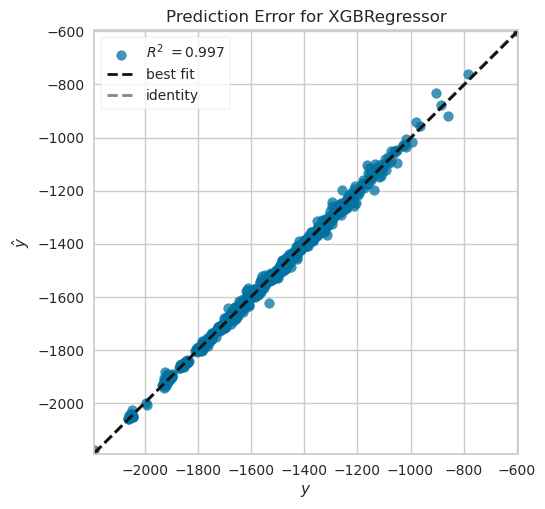

In [13]:
from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
visualizer = PredictionError(xgb.XGBRegressor(**params, n_estimators=num_iters, random_state=rand_state))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()  